In [112]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.metrics import mean_squared_error

In [3]:
import datetime as dt
print(dt.datetime.now())

2025-03-20 17:09:00.018237


In [55]:
# Retreiving past data
stock_name = "NVDA"
df = yf.download(stock_name, "2023-10-01", "2025-01-01", progress = False)
df

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2023-10-02,44.761250,45.154065,43.840675,44.009595,433298000
2023-10-03,43.496838,45.109093,43.225963,44.787240,470850000
2023-10-04,44.020599,44.122553,43.271946,43.721738,361821000
2023-10-05,44.667297,44.879201,43.867669,44.029592,393483000
2023-10-06,45.740803,45.767791,44.005607,44.172529,434436000
...,...,...,...,...,...
2024-12-24,140.207108,141.886946,138.637245,139.987127,105157000
2024-12-26,139.917130,140.837058,137.717335,139.687155,116205600


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 2023-10-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   315 non-null    float64
 1   (High, NVDA)    315 non-null    float64
 2   (Low, NVDA)     315 non-null    float64
 3   (Open, NVDA)    315 non-null    float64
 4   (Volume, NVDA)  315 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 14.8 KB


In [57]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
count,315.000000,315.000000,315.000000,315.000000,3.150000e+02
mean,95.504013,97.241214,93.605021,95.551425,3.866366e+08
std,34.483090,35.196466,33.824594,34.638802,1.539348e+08
min,40.307320,40.860065,39.211827,40.431263,1.051570e+08
25%,61.173529,62.002720,60.232884,60.609242,2.724606e+08
50%,94.598907,95.787522,92.471608,93.910139,3.778310e+08
75%,126.398849,129.088190,123.619531,126.439264,4.749455e+08
max,148.856064,152.865409,146.236457,149.325985,1.142269e+09


In [58]:
# tech indicator sma20, sma50
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()

# Exponential Moving Average (EMA)
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 2023-10-02 to 2024-12-31
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   315 non-null    float64
 1   (High, NVDA)    315 non-null    float64
 2   (Low, NVDA)     315 non-null    float64
 3   (Open, NVDA)    315 non-null    float64
 4   (Volume, NVDA)  315 non-null    int64  
 5   (SMA20, )       296 non-null    float64
 6   (SMA50, )       266 non-null    float64
 7   (EMA20, )       315 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 22.1 KB


In [60]:
df.columns = df.columns.droplevel(1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 2023-10-02 to 2024-12-31
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   315 non-null    float64
 1   High    315 non-null    float64
 2   Low     315 non-null    float64
 3   Open    315 non-null    float64
 4   Volume  315 non-null    int64  
 5   SMA20   296 non-null    float64
 6   SMA50   266 non-null    float64
 7   EMA20   315 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 22.1 KB


In [62]:
df = df.reset_index()

# Null value dates -sma20, sma50
na_dates_sma20 = df[df['SMA20'].isnull()]['Date']
na_dates_sma50 = df[df['SMA50'].isnull()]['Date']

# Print the dates
print("Dates with null values in SMA20:")
print(na_dates_sma20)

print("\nDates with null values in SMA50:")
print(na_dates_sma50)

Dates with null values in SMA20:
0    2023-10-02
1    2023-10-03
2    2023-10-04
3    2023-10-05
4    2023-10-06
5    2023-10-09
6    2023-10-10
7    2023-10-11
8    2023-10-12
9    2023-10-13
10   2023-10-16
11   2023-10-17
12   2023-10-18
13   2023-10-19
14   2023-10-20
15   2023-10-23
16   2023-10-24
17   2023-10-25
18   2023-10-26
Name: Date, dtype: datetime64[ns]

Dates with null values in SMA50:
0    2023-10-02
1    2023-10-03
2    2023-10-04
3    2023-10-05
4    2023-10-06
5    2023-10-09
6    2023-10-10
7    2023-10-11
8    2023-10-12
9    2023-10-13
10   2023-10-16
11   2023-10-17
12   2023-10-18
13   2023-10-19
14   2023-10-20
15   2023-10-23
16   2023-10-24
17   2023-10-25
18   2023-10-26
19   2023-10-27
20   2023-10-30
21   2023-10-31
22   2023-11-01
23   2023-11-02
24   2023-11-03
25   2023-11-06
26   2023-11-07
27   2023-11-08
28   2023-11-09
29   2023-11-10
30   2023-11-13
31   2023-11-14
32   2023-11-15
33   2023-11-16
34   2023-11-17
35   2023-11-20
36   2023-11-21
37 

In [63]:
df.drop(index = df.index[:63], inplace = True)

In [64]:
df

Price,Date,Close,High,Low,Open,Volume,SMA20,SMA50,EMA20
63,2024-01-02,48.149918,49.276493,47.577135,49.225514,411254000,48.122378,46.786128,48.460359
64,2024-01-03,47.551144,48.165911,47.302237,47.467176,320896000,48.225489,46.909794,48.373767
65,2024-01-04,47.979984,48.481795,47.490167,47.749068,306535000,48.297063,47.010292,48.336264
66,2024-01-05,49.078564,49.528395,48.287860,48.443804,415039000,48.476695,47.119008,48.406959
67,2024-01-08,52.233383,52.255378,49.460426,49.493415,642510000,48.759439,47.328483,48.771381
...,...,...,...,...,...,...,...,...,...
310,2024-12-24,140.207108,141.886946,138.637245,139.987127,105157000,137.154008,139.741147,137.028501
311,2024-12-26,139.917130,140.837058,137.717335,139.687155,116205600,137.304966,139.907913,137.303608
312,2024-12-27,136.997391,139.007216,134.697615,138.537258,170582600,137.388924,139.933897,137.274445
313,2024-12-30,137.477356,140.257099,134.007674,134.817597,167734700,137.351404,139.945285,137.293770


In [65]:
df.reset_index(drop = True, inplace = True)

In [67]:
df

Price,Date,Close,High,Low,Open,Volume,SMA20,SMA50,EMA20
0,2024-01-02,48.149918,49.276493,47.577135,49.225514,411254000,48.122378,46.786128,48.460359
1,2024-01-03,47.551144,48.165911,47.302237,47.467176,320896000,48.225489,46.909794,48.373767
2,2024-01-04,47.979984,48.481795,47.490167,47.749068,306535000,48.297063,47.010292,48.336264
3,2024-01-05,49.078564,49.528395,48.287860,48.443804,415039000,48.476695,47.119008,48.406959
4,2024-01-08,52.233383,52.255378,49.460426,49.493415,642510000,48.759439,47.328483,48.771381
...,...,...,...,...,...,...,...,...,...
247,2024-12-24,140.207108,141.886946,138.637245,139.987127,105157000,137.154008,139.741147,137.028501
248,2024-12-26,139.917130,140.837058,137.717335,139.687155,116205600,137.304966,139.907913,137.303608
249,2024-12-27,136.997391,139.007216,134.697615,138.537258,170582600,137.388924,139.933897,137.274445
250,2024-12-30,137.477356,140.257099,134.007674,134.817597,167734700,137.351404,139.945285,137.293770


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Close   252 non-null    float64       
 2   High    252 non-null    float64       
 3   Low     252 non-null    float64       
 4   Open    252 non-null    float64       
 5   Volume  252 non-null    int64         
 6   SMA20   252 non-null    float64       
 7   SMA50   252 non-null    float64       
 8   EMA20   252 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 17.8 KB


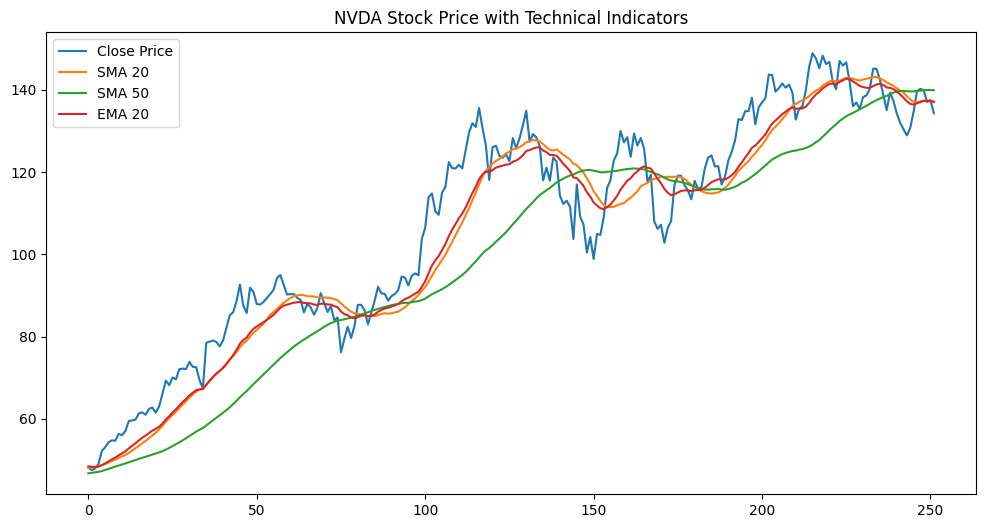

In [70]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['SMA20'], label='SMA 20')
plt.plot(df['SMA50'], label='SMA 50')
plt.plot(df['EMA20'], label='EMA 20')
plt.title(f'{stock_name} Stock Price with Technical Indicators')
plt.legend()
plt.show()

In [77]:
data = df['Close'].values.reshape(-1, 1)
data

array([[ 48.1499176 ],
       [ 47.55114365],
       [ 47.97998428],
       [ 49.07856369],
       [ 52.23338318],
       [ 53.12005234],
       [ 54.32960129],
       [ 54.8014183 ],
       [ 54.68946075],
       [ 56.36083603],
       [ 56.03195953],
       [ 57.08556366],
       [ 59.46866989],
       [ 59.63161087],
       [ 59.8505249 ],
       [ 61.33896637],
       [ 61.59386444],
       [ 61.00809097],
       [ 62.44155121],
       [ 62.75043488],
       [ 61.50390625],
       [ 63.00333786],
       [ 66.13516235],
       [ 69.30597687],
       [ 68.19739532],
       [ 70.07267761],
       [ 69.61484528],
       [ 72.10593414],
       [ 72.2208786 ],
       [ 72.10093689],
       [ 73.87226105],
       [ 72.63072205],
       [ 72.58573914],
       [ 69.42593384],
       [ 67.44667816],
       [ 78.50852203],
       [ 78.78741455],
       [ 79.06232452],
       [ 78.67144775],
       [ 77.63385773],
       [ 79.08229828],
       [ 82.24810791],
       [ 85.2049942 ],
       [ 85

In [79]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [96]:
len(scaled_data)
scaled_data

array([[0.00591061],
       [0.        ],
       [0.00423317],
       [0.01507745],
       [0.04621927],
       [0.05497175],
       [0.06691144],
       [0.07156883],
       [0.07046368],
       [0.08696214],
       [0.08371574],
       [0.09411606],
       [0.11764015],
       [0.11924857],
       [0.12140952],
       [0.1361022 ],
       [0.13861835],
       [0.13283607],
       [0.14698603],
       [0.15003507],
       [0.13773035],
       [0.15253153],
       [0.18344636],
       [0.21474607],
       [0.20380305],
       [0.22231432],
       [0.21779497],
       [0.24238497],
       [0.24351961],
       [0.24233565],
       [0.25982072],
       [0.24756525],
       [0.24712122],
       [0.21593019],
       [0.19639258],
       [0.30558613],
       [0.30833913],
       [0.31105282],
       [0.3071944 ],
       [0.29695215],
       [0.31124998],
       [0.34250029],
       [0.37168827],
       [0.3789018 ],
       [0.40590049],
       [0.4450663 ],
       [0.39433533],
       [0.377

In [93]:
# lstm seq
def make_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:(i + seq_len)])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60  # Number of days to look back
X, y = make_sequences(scaled_data, sequence_length)
len(X)

192

In [97]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [105]:
# build lstm
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.summary()
Model: "sequential_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 31,901 (124.61 KB)
 Trainable params: 31,901 (124.61 KB)
 Non-trainable params: 0 (0.00 B)

In [106]:
# train
history = model.fit(X_train, y_train,
                   batch_size=32,
                   epochs=50,
                   validation_split=0.1,
                   verbose=1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - loss: 0.3593 - val_loss: 0.0917
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0408 - val_loss: 0.0050
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0258 - val_loss: 0.0529
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0235 - val_loss: 0.0591
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0190 - val_loss: 0.0156
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0147 - val_loss: 0.0031
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0143 - val_loss: 0.0136
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0119 - val_loss: 0.0282
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0137 - val_loss: 0.0176
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0128 - val_loss: 0.0087
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0120 - val_loss: 0.0111
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0116 - val_loss: 0.018

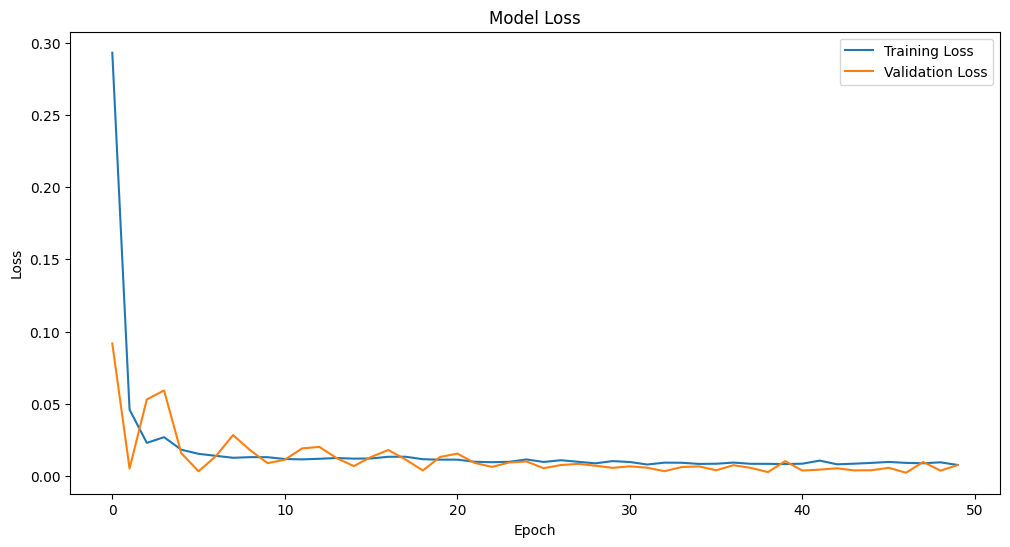

In [107]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [118]:
# predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [119]:
# correct shape for inverse transform
train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)

# inv trf pred. vs actual values
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

# calc(rmse)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 7.91
Test RMSE: 8.17


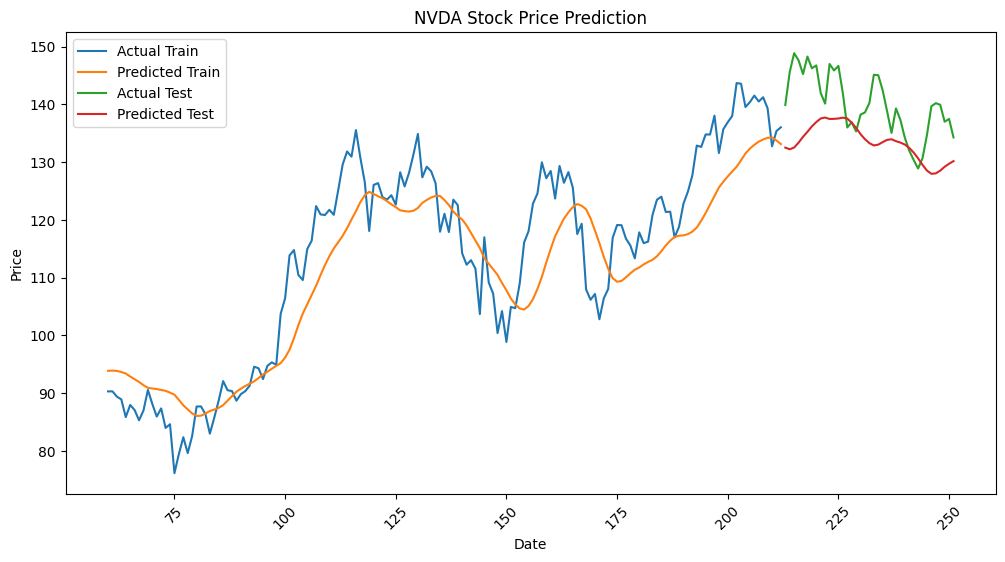

In [122]:
plt.figure(figsize=(12,6))
plt.plot(df.index[sequence_length:train_size+sequence_length], y_train_inv, label='Actual Train')
plt.plot(df.index[sequence_length:train_size+sequence_length], train_predict, label='Predicted Train')
plt.plot(df.index[train_size+sequence_length:], y_test_inv, label='Actual Test')
plt.plot(df.index[train_size+sequence_length:], test_predict, label='Predicted Test')

plt.title(f'{stock_name} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [136]:
df['Date']

,Date
0,2024-01-02
1,2024-01-03
2,2024-01-04
3,2024-01-05
4,2024-01-08
...,...
247,2024-12-24
248,2024-12-26
249,2024-12-27
250,2024-12-30


In [150]:
# use last_sequence days to predict future
last_sequence = scaled_data[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, 1))

future_predictions = []
n_days = 30  # Predict next 30 days
for _ in range(n_days):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0,0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0,-1,0] = next_pred[0,0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [151]:
print("Raw future predictions (before inverse transform):", future_predictions[:5])

Raw future predictions (before inverse transform): [np.float32(0.8169959), np.float32(0.8139006), np.float32(0.80826586), np.float32(0.80112827), np.float32(0.7931535)]


In [152]:
# inv trf future pred.
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

# Create future dates
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=n_days+1)[1:]

In [153]:
print("last_date:", last_date)
print("future_dates:", future_dates[:5], "...", future_dates[-5:])

last_date: 2024-12-31 00:00:00
future_dates: DatetimeIndex(['2025-01-01', '2025-01-02', '2025-01-03', '2025-01-04',
               '2025-01-05'],
              dtype='datetime64[ns]', freq='D') ... DatetimeIndex(['2025-01-26', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30'],
              dtype='datetime64[ns]', freq='D')


In [154]:
historical_dates = df['Date'].iloc[-100:]
print(historical_dates)

152   2024-08-09
153   2024-08-12
154   2024-08-13
155   2024-08-14
156   2024-08-15
         ...    
247   2024-12-24
248   2024-12-26
249   2024-12-27
250   2024-12-30
251   2024-12-31
Name: Date, Length: 100, dtype: datetime64[ns]


In [181]:
print(future_dates)

DatetimeIndex(['2025-01-01', '2025-01-02', '2025-01-03', '2025-01-04',
               '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08',
               '2025-01-09', '2025-01-10', '2025-01-11', '2025-01-12',
               '2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16',
               '2025-01-17', '2025-01-18', '2025-01-19', '2025-01-20',
               '2025-01-21', '2025-01-22', '2025-01-23', '2025-01-24',
               '2025-01-25', '2025-01-26', '2025-01-27', '2025-01-28',
               '2025-01-29', '2025-01-30'],
              dtype='datetime64[ns]', freq='D')


In [183]:
print(future_predictions)

[[130.31685 ]
 [130.00328 ]
 [129.43245 ]
 [128.70938 ]
 [127.9015  ]
 [127.05148 ]
 [126.18628 ]
 [125.32271 ]
 [124.47139 ]
 [123.63886 ]
 [122.82907 ]
 [122.04442 ]
 [121.28617 ]
 [120.554924]
 [119.850815]
 [119.17371 ]
 [118.523155]
 [117.89863 ]
 [117.29949 ]
 [116.72499 ]
 [116.17434 ]
 [115.64677 ]
 [115.14143 ]
 [114.65751 ]
 [114.19415 ]
 [113.75059 ]
 [113.32595 ]
 [112.919495]
 [112.53044 ]
 [112.15805 ]]


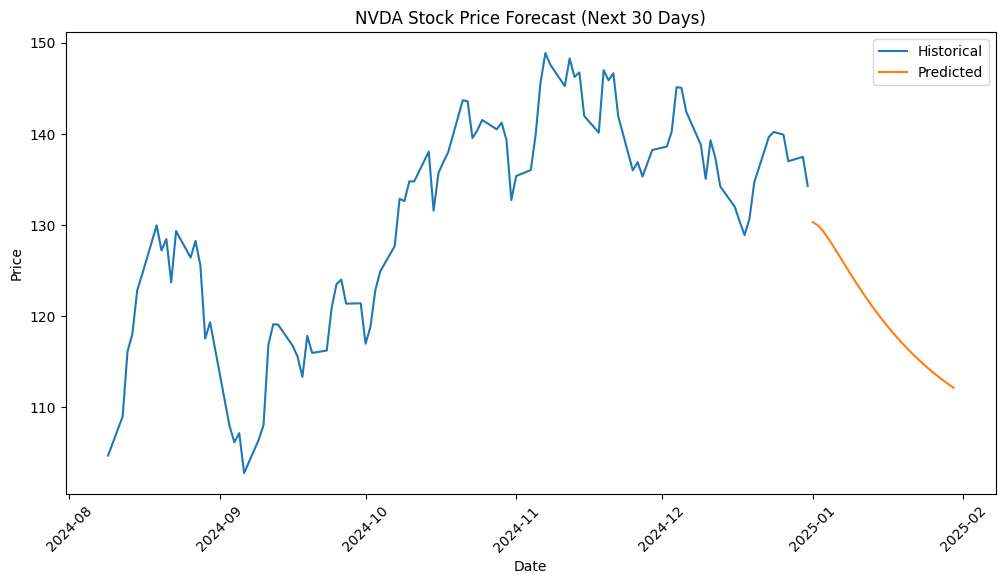

In [155]:
plt.figure(figsize=(12,6))
plt.plot(historical_dates, df['Close'][-100:], label='Historical')
plt.plot(future_dates, future_predictions, label='Predicted')
plt.title(f'{stock_name} Stock Price Forecast (Next {n_days} Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

[*********************100%***********************]  1 of 1 completed


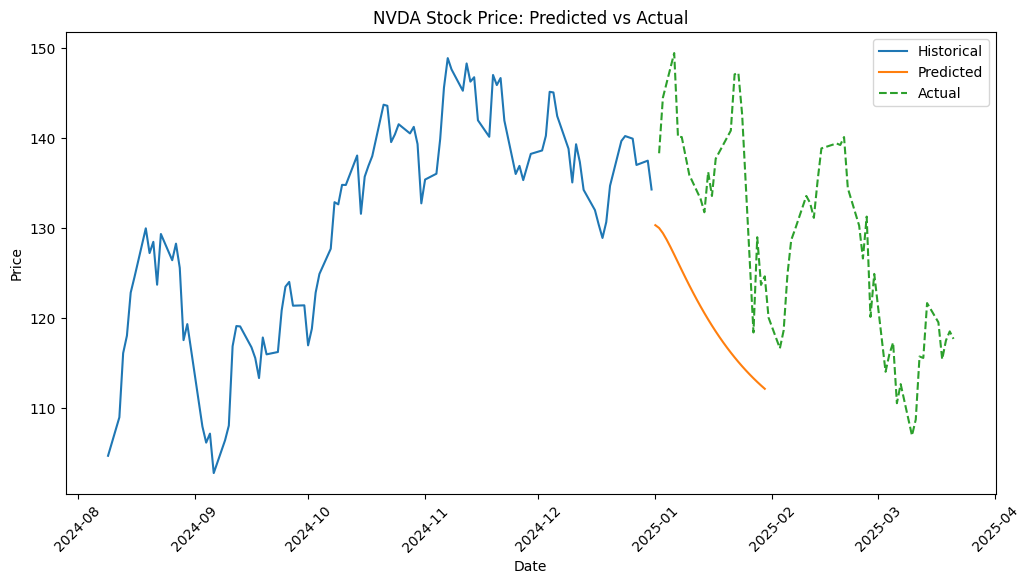

In [156]:
# Add this cell to fetch actual data
actual_df = yf.download('NVDA', start='2025-01-01', end='2025-03-23')
plt.figure(figsize=(12,6))
plt.plot(historical_dates, df['Close'][-100:], label='Historical')
plt.plot(future_dates, future_predictions, label='Predicted')
plt.plot(actual_df.index, actual_df['Close'], label='Actual', linestyle='--')
plt.title('NVDA Stock Price: Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [185]:
# Define the continuous date range to query
start_date = '2025-01-15'
end_date = '2025-01-25'
date_range = pd.date_range(start=start_date, end=end_date)

for future_date_sample in date_range:
    # pred. price
    idx = future_dates.to_list().index(pd.to_datetime(future_date_sample))
    predicted_price = future_predictions[idx, 0]

    date_str = future_date_sample.strftime('%Y-%m-%d')
    print(f"\nDate: {date_str}")
    print(f"Predicted price: ${predicted_price:.2f}")

    # actual close price
    try:
        closing_price = actual_df.loc[date_str, 'Close'].iloc[0]
        print(f"Actual close price: ${closing_price}")

        # Calculate the prediction error
        error = abs(predicted_price - closing_price)
        error_percent = (error / closing_price) * 100
        print(f"Prediction Error: ${error:.2f} ({error_percent:.2f}% off)")

    except KeyError:
        print(f"non trading day, Skipping.")


Date: 2025-01-15
Predicted price: $119.85
Actual close price: $136.22747802734375
Prediction Error: $16.38 (12.02% off)

Date: 2025-01-16
Predicted price: $119.17
Actual close price: $133.55772399902344
Prediction Error: $14.38 (10.77% off)

Date: 2025-01-17
Predicted price: $118.52
Actual close price: $137.6973419189453
Prediction Error: $19.17 (13.92% off)

Date: 2025-01-18
Predicted price: $117.90
non trading day, Skipping.

Date: 2025-01-19
Predicted price: $117.30
non trading day, Skipping.

Date: 2025-01-20
Predicted price: $116.72
non trading day, Skipping.

Date: 2025-01-21
Predicted price: $116.17
Actual close price: $140.81704711914062
Prediction Error: $24.64 (17.50% off)

Date: 2025-01-22
Predicted price: $115.65
Actual close price: $147.05648803710938
Prediction Error: $31.41 (21.36% off)

Date: 2025-01-23
Predicted price: $115.14
Actual close price: $147.2064666748047
Prediction Error: $32.07 (21.78% off)

Date: 2025-01-24
Predicted price: $114.66
Actual close price: $14